In [ ]:
!pip install pyspark

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.sql.functions import col

from sklearn.preprocessing import MinMaxScaler

In [ ]:
#MACHINE LEARNING EXPLORATION
house_df = pd.read_csv("/content/csvdata.csv")

In [ ]:
house_df.describe("Price", "Area").show()

+-------+--------------------+------------------+
|summary|               Price|              Area|
+-------+--------------------+------------------+
|  count|               29135|             29135|
|   mean|1.1952667000034323E7|1301.8164750300325|
| stddev| 2.387646511511032E7| 767.8623393376763|
|    min|             2000000|               200|
|    max|           854599999|             16000|
+-------+--------------------+------------------+



In [ ]:
house_df = house_df.rename(columns = {"No. of Bedrooms" : "Bedrooms"})

In [ ]:
city_dic = {}
for i, city in enumerate(house_df["City"].unique()):
  city_dic[city] = i+1

loc_dic = {}
for i, loc in enumerate(house_df['Location'].unique()):
  loc_dic[loc] = (i+1) * 0.001

In [ ]:
house_df["City"] = house_df["City"].map(city_dic)
house_df["Location"] = house_df["Location"].map(loc_dic)

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("House Price Analysis") \
    .getOrCreate()

house_df = spark.createDataFrame(house_df)

house_df.createOrReplaceTempView("house_df")

In [ ]:
house_df.groupBy("Bedrooms").agg({"Price": "avg"}).show()

+--------+--------------------+
|Bedrooms|          avg(Price)|
+--------+--------------------+
|       7|          2.207575E7|
|       6|4.0980645161290325E7|
|       5|  5.92507178019802E7|
|       1|    9907474.07217695|
|       3|1.2281762022109298E7|
|       8|              7.67E7|
|       2|   9722289.346963465|
|       4|2.2864084472737186E7|
|       9|           2400000.0|
+--------+--------------------+



In [ ]:
house_df.groupBy("Area").agg({"Price": "avg"}).show()

+----+--------------------+
|Area|          avg(Price)|
+----+--------------------+
|1950|1.9180102512820512E7|
|2927|               3.1E7|
|2040|        1.07981998E7|
|1697|   8789666.555555556|
|2529|           4100000.0|
| 964|            2.3479E7|
|1806|             1.238E7|
|2250|2.7204945891891893E7|
|1224|   8964866.666666666|
|1360|   8200722.152777778|
|1277|   8142217.391304348|
|1258|   6162714.285714285|
|1010|   8710637.666666666|
|3800| 4.390455544444445E7|
|3015|3.2433333333333332E7|
|1840|            1.0343E7|
| 541|           5468000.0|
| 558|           4825000.0|
|1145|    9023548.35483871|
|1409|        1.29295998E7|
+----+--------------------+
only showing top 20 rows



In [ ]:
train_data, test_data = house_df.randomSplit([0.8, 0.2], seed=123)

In [ ]:
assembler = VectorAssembler(inputCols=["Bedrooms", "City", "Area"], outputCol="features")
train_data = assembler.transform(train_data)
test_data = assembler.transform(test_data)

lr = LinearRegression(featuresCol="features", labelCol="Price")
lr_model = lr.fit(train_data)

In [ ]:
predictions = lr_model.transform(test_data)

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol="Price", predictionCol="prediction", metricName="mae")
mae = evaluator.evaluate(predictions)
print("Mean Absolute Error (MAE):", mae)

mse = evaluator.evaluate(predictions, {evaluator.metricName: "mse"})
print("Mean Squared Error (MSE):", mse)

rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})
print("Root Mean Squared Error (RMSE):", rmse)

r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})
print("R-squared (R^2) Score:", r2)


Mean Absolute Error (MAE): 8240229.974782666
Mean Squared Error (MSE): 398551842761000.9
Root Mean Squared Error (RMSE): 19963763.241458282
R-squared (R^2) Score: 0.08609373606114634


In [ ]:
# DATA ANALYSIS WITH PYSPARK
#dataframe API
house_df.describe("Price", "Area").show()

+-------+--------------------+------------------+
|summary|               Price|              Area|
+-------+--------------------+------------------+
|  count|               29135|             29135|
|   mean|1.1952667000034323E7|1301.8164750300325|
| stddev| 2.387646511511032E7| 767.8623393376763|
|    min|             2000000|               200|
|    max|           854599999|             16000|
+-------+--------------------+------------------+



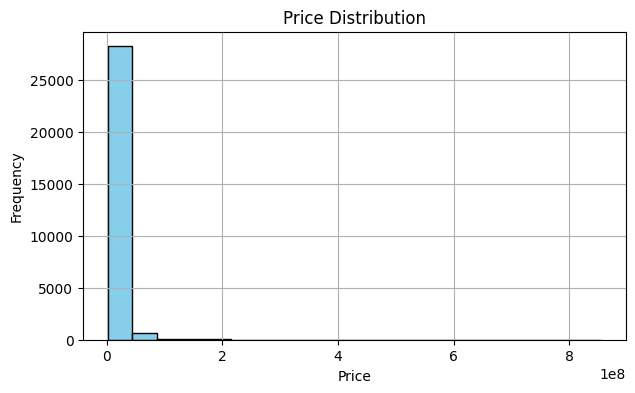

In [ ]:
price_distribution = house_df.select("Price").toPandas()

# Create a histogram of the price distribution
plt.figure(figsize=(7, 4))
plt.hist(price_distribution['Price'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Price Distribution')
plt.grid(True)
plt.show()

In [ ]:
# SQL API
spark.sql("""SELECT COUNT(*) AS total_records, AVG(Price) AS avg_price, MEDIAN(Price) AS median_price, STDDEV(Price) AS std_dev_price
FROM house_df""").show()

+-------------+--------------------+------------+-------------------+
|total_records|           avg_price|median_price|      std_dev_price|
+-------------+--------------------+------------+-------------------+
|        29135|1.1952667000034323E7|   6884999.0|2.387646511511032E7|
+-------------+--------------------+------------+-------------------+



In [ ]:
spark.sql("SELECT City, COUNT(*) AS count FROM house_df GROUP BY City").show()

+----+-----+
|City|count|
+----+-----+
|   1| 5521|
|   3| 4109|
|   2| 4307|
|   4| 1998|
|   6| 6925|
|   5| 6275|
+----+-----+

